In [1]:
class Polynomial:
    def __init__(self, terms = None):
        # We store each term as an entry in the dictionary as ((var1, deg), (var2, deg), ...): coefficient,
        # where var1 index < var2 index < ...
        # For example, x0**2x2 - 2x0x1 + 1 will be { ((0, 2), (2, 1)): 1, ((0, 1), (1, 1)): -2, (): 1 }.
        if terms == None:
            terms = {}
        self.terms = terms.copy()
    
    def __neg__(self):
        terms = self.terms.copy()
        for variables in terms:
            terms[variables] *= -1
        return Polynomial(terms)
    
    def __add__(self, other):
        if type(other) == int or type(other) is float:
            other = const(other)
        assert type(other) == Polynomial

        terms = self.terms.copy()
        for (variables, coefficient) in other.terms.items():
            if variables in terms:
                terms[variables] += coefficient
                if abs(terms[variables]) < 1e-9:
                    del terms[variables]
            else:
                terms[variables] = coefficient
        
        return Polynomial(terms)

    def __radd__(self, other):
        return self + other

    def __sub__(self, other):
        if type(other) == int or type(other) is float:
            other = const(other)
        assert type(other) == Polynomial

        terms = self.terms.copy()
        for (variables, coefficient) in other.terms.items():
            if variables in terms:
                terms[variables] -= coefficient
                if abs(terms[variables]) < 1e-9:
                    del terms[variables]
            else:
                terms[variables] = -coefficient
        
        return Polynomial(terms)

    def __rsub__(self, other):
       return -(self - other)

    def __mul__(self, other):
        if type(other) == int or type(other) is float:
            other = const(other)
        assert type(other) == Polynomial

        terms = {}
        for (variables1, coefficient1) in self.terms.items():
            for (variables2, coefficient2) in other.terms.items():
                coefficient = coefficient1 * coefficient2
                variables = {}
                for (variable, degree) in variables1:
                    variables[variable] = degree
                for (variable, degree) in variables2:
                    if variable in variables:
                        variables[variable] += degree
                    else:
                        variables[variable] = degree
                variables = tuple(sorted(list(variables.items())))
                
                if variables in terms:
                    terms[variables] += coefficient
                else:
                    terms[variables] = coefficient

        terms_keys = list(terms.keys())
        for key in terms_keys:
            if terms[key] == 0:
                del terms[key]
        
        return Polynomial(terms)

    def __rmul__(self, other):
        return self * other

    def __pow__(self, other):
        res = const(1)
        for _ in range(other):
            res *= self
        return res

    def __repr__(self):
        return " + ".join([
            f"{coefficient if coefficient != 1 or len(variables) == 0 else ""}" + "".join([
                f"x{index}{f"^{degree}" if degree != 1 else ""}" for (index, degree) in variables
            ])
            for (variables, coefficient) in self.terms.items()
        ])
    
    def number_of_variables(self):
        res = 0
        for variables in self.terms:
            for (index, _) in variables:
                res = max(res, index + 1)
        return res

    def __call__(self, val):
        if type(val) == float or type(val) == int:
            val = (val,)
        assert len(val) == self.number_of_variables()

        res = 0
        for (variables, coefficient) in self.terms.items():
            prod = coefficient
            for (index, degree) in variables:
                prod *= val[index] ** degree
            res += prod
        return res

def const(val):
    return Polynomial({(): val})

def var(index):
    return Polynomial({((index, 1),): 1})

In [2]:
import random

def integral(polynomial: Polynomial, region):
    if type(region[0]) == int or type(region[0]) == float:
        region = [region]
    n = polynomial.number_of_variables()
    assert n == len(region)

    res = 0
    for (variables, coefficient) in polynomial.terms.items():
        degrees = [0] * n
        for (index, degree) in variables:
            degrees[index] = degree
        
        integral = coefficient
        for i in range(n):
            integral *= region[i][1] ** (degrees[i] + 1) / (degrees[i] + 1) - region[i][0] ** (degrees[i] + 1) / (degrees[i] + 1)
        res += integral
    
    return res

def grid_integral(f, region, n = 10, cell_offset = 0.0):
    if type(region[0]) == int or type(region[0]) == float:
        region = [region]

    counter = [0] * len(region)
    res = 0
    cell_volume = 1
    for (a, b) in region:
        cell_volume *= (b - a) / n

    loop = True
    while loop:
        res += f([region[i][0] + (counter[i] + cell_offset) / n * (region[i][1] - region[i][0]) for i in range(len(counter))]) * cell_volume
        loop = False
        for i in range(len(counter) - 1, -1, -1):
            if counter[i] == n - 1:
                counter[i] = 0
            else:
                counter[i] += 1
                loop = True
                break
    return res

def monte_carlo_integral(f, region, n = 10):
    if type(region[0]) == int or type(region[0]) == float:
        region = [region]

    res = 0
    for _ in range(n):
        x = [region[i][0] + random.random() * (region[i][1] - region[i][0]) for i in range(len(region))]
        res += f(x)
    res /= n

    volume = 1
    for (a, b) in region:
        volume *= (b - a)
    res *= volume

    return res

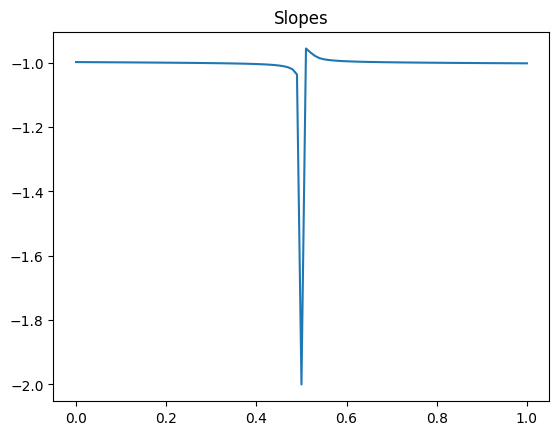

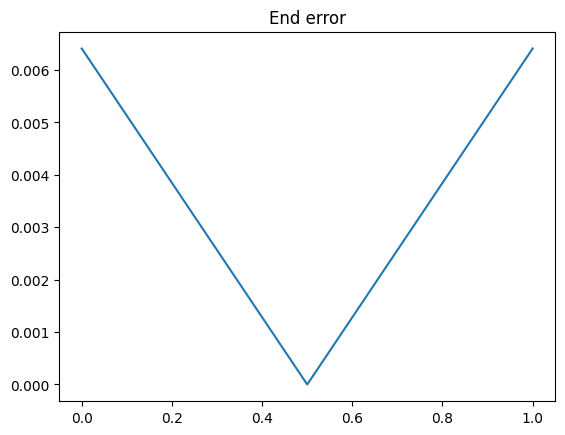

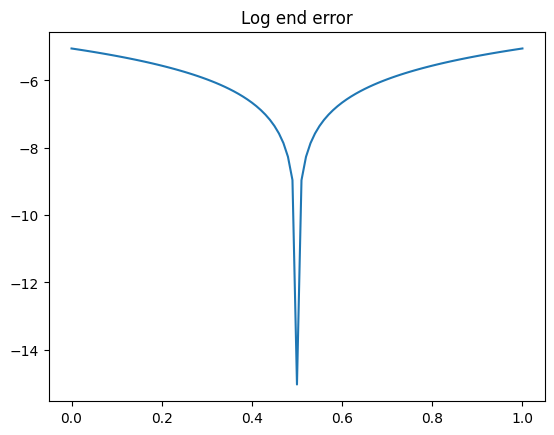

In [3]:
# Effect of offset

import matplotlib.pyplot as plt
import math
import random
from sklearn.linear_model import LinearRegression

x0 = var(0)
x1 = var(1)
x2 = var(2)
x3 = var(3)
x4 = var(4)
polynomial = (20 * random.random() - 10) * x0 ** 2 + (20 * random.random() - 10) * x0 + (20 * random.random() - 10)
region = (0, 1)

actual_integral = integral(polynomial, region)

N = 1000
offsets = [i / 100 * 1.0 for i in range(0, 101)]
slopes = []
end_errors = []
for offset in offsets:
    errors = []
    for i in range(1, N + 1):
        errors.append(abs(actual_integral - grid_integral(polynomial, region, i, cell_offset=offset)))
    line = LinearRegression().fit([[math.log(i)] for i in range(1, N + 1)], [math.log(err) for err in errors])
    slopes.append(line.coef_[0])
    end_errors.append(errors[-1])

plt.plot(offsets, slopes)
plt.title('Slopes')
plt.show()

plt.plot(offsets, end_errors)
plt.title('End error')
plt.show()

plt.plot(offsets, [math.log(err) for err in end_errors])
plt.title('Log end error')
plt.show()

1
Grid integral time 16.04292607307434
Grid integral abs error 0.12720373508075156
Midpoint grid integral time 16.12250518798828
Midpoint grid integral abs error 0.007132261149468633
Monte carlo integral time 2.6341731548309326
Monte carlo abs error 0.01295299410299755
Prob that monte carlo is better 0.19


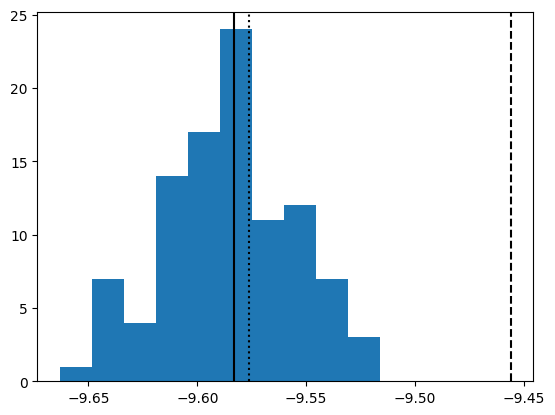

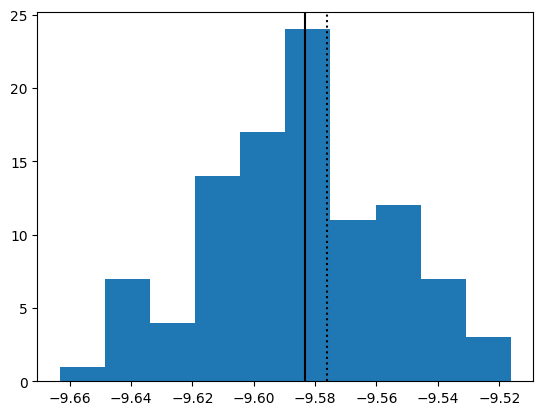

2
Grid integral time 15.908860921859741
Grid integral abs error 2.1389098899617505
Midpoint grid integral time 16.134966611862183
Midpoint grid integral abs error 0.004696042908491904
Monte carlo integral time 2.5072543621063232
Monte carlo abs error 0.028926090963016904
Prob that monte carlo is better 0.12


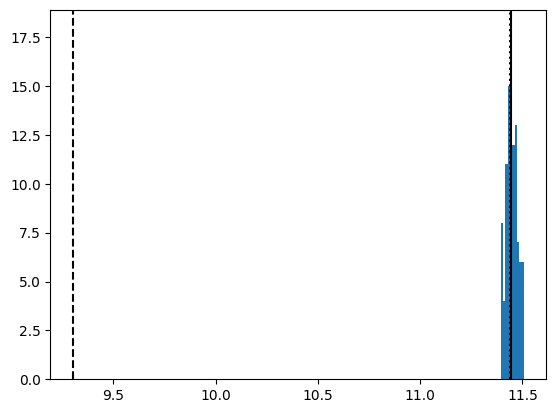

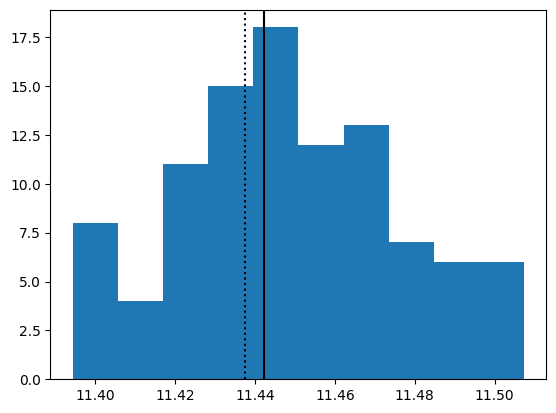

3
Grid integral time 15.877946138381958
Grid integral abs error 2.2631295681993544
Midpoint grid integral time 16.04497981071472
Midpoint grid integral abs error 0.05657651444102127
Monte carlo integral time 2.50685977935791
Monte carlo abs error 0.03414687587171389
Prob that monte carlo is better 0.96


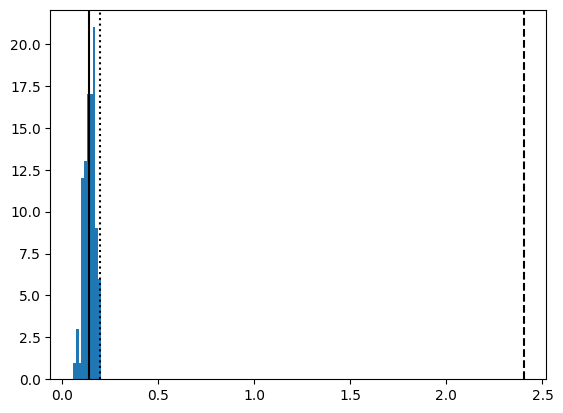

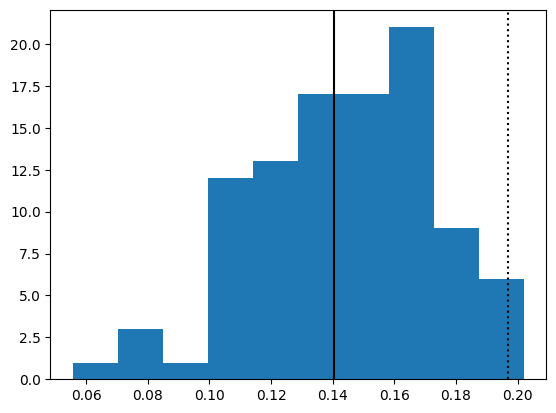

4
Grid integral time 15.95737099647522
Grid integral abs error 0.40410581671955903
Midpoint grid integral time 16.263332843780518
Midpoint grid integral abs error 0.015500076708750754
Monte carlo integral time 2.5438201427459717
Monte carlo abs error 0.047191077335488885
Prob that monte carlo is better 0.43


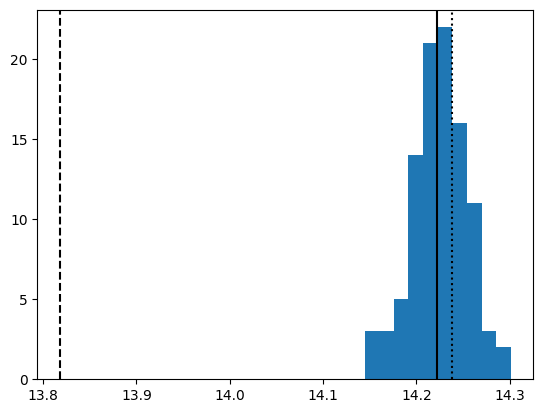

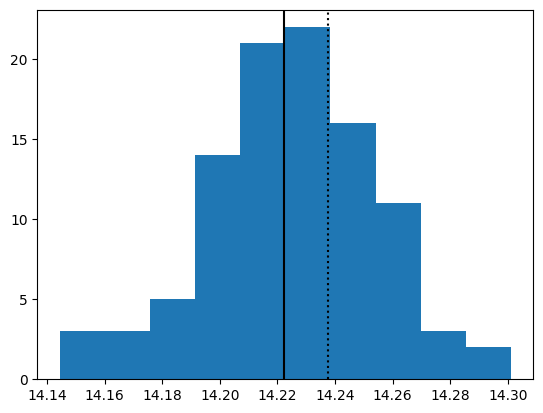

5
Grid integral time 15.017006635665894
Grid integral abs error 1.3881192926735668
Midpoint grid integral time 15.241670370101929
Midpoint grid integral abs error 0.025244491054953855
Monte carlo integral time 2.3530354499816895
Monte carlo abs error 0.01047784417223152
Prob that monte carlo is better 0.59


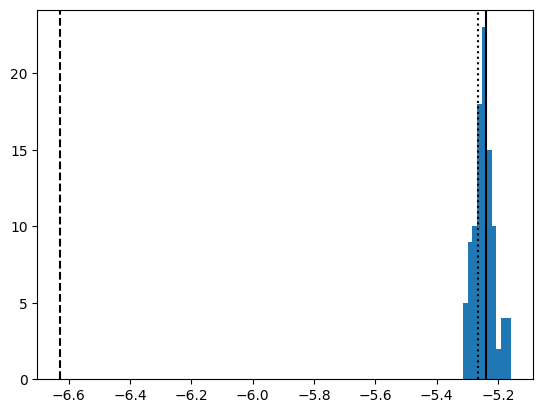

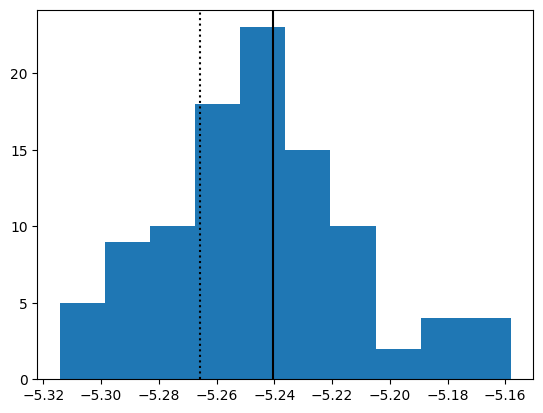

In [4]:
# Grid (0 offset) vs Monte carlo

# Speed up computation of monte carlo using numpy
# https://stackoverflow.com/a/48180596

import time
import numpy as np

for i in range(5):
    print(i + 1)
    polynomial = 0
    coefficients = []
    degrees = []
    for i in range(3):
        for j in range(3):
            for k in range(3):
                for l in range(3):
                    for m in range(3):
                        coefficient = 20 * random.random() - 10
                        polynomial += coefficient * x0 ** i * x1 ** j * x2 ** k * x3 ** l * x4 ** m
                        coefficients.append(coefficient)
                        degrees.append((i, j, k, l, m))
    region = [(0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]

    grid_n = 10
    monte_carlo_n = grid_n ** len(region)

    actual_integral = integral(polynomial, region)

    start = time.time()
    grid_estimate = grid_integral(polynomial, region, grid_n)
    print('Grid integral time', time.time() - start)
    print('Grid integral abs error', abs(grid_estimate - actual_integral))

    start = time.time()
    midpoint_grid_estimate = grid_integral(polynomial, region, grid_n, cell_offset=0.5)
    print('Midpoint grid integral time', time.time() - start)
    print('Midpoint grid integral abs error', abs(midpoint_grid_estimate - actual_integral))

    start = time.time()
    volume = 1
    x = np.random.rand(monte_carlo_n, len(region))
    monte_carlo_estimate = volume * np.stack([c * ((x ** d).prod(axis=1)) for (c, d) in zip(coefficients, degrees)]).sum() / monte_carlo_n
    print('Monte carlo integral time', time.time() - start)
    print('Monte carlo abs error', abs(monte_carlo_estimate - actual_integral))

    N = 100
    monte_better_count = 0
    monte_carlo_integrals = []
    for c in range(N):
        volume = 1
        x = np.random.rand(monte_carlo_n, len(region))
        monte_carlo_estimate = volume * np.stack([c * ((x ** d).prod(axis=1)) for (c, d) in zip(coefficients, degrees)]).sum() / monte_carlo_n
        monte_carlo_integrals.append(monte_carlo_estimate)
        if abs(monte_carlo_estimate - actual_integral) < min(abs(grid_estimate - actual_integral), abs(midpoint_grid_estimate - actual_integral)):
            monte_better_count += 1
    print('Prob that monte carlo is better', monte_better_count / N)

    plt.hist(monte_carlo_integrals)
    plt.axvline(x = actual_integral, color = "black")
    plt.axvline(x = grid_estimate, color = "black", linestyle="--")
    plt.axvline(x = midpoint_grid_estimate, color = "black", linestyle=":")
    plt.show()

    plt.hist(monte_carlo_integrals)
    plt.axvline(x = actual_integral, color = "black")
    plt.axvline(x = midpoint_grid_estimate, color = "black", linestyle=":")
    plt.show()